In [1]:
!pip install zarr

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.5 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=c24c04995aa6d8a9fbda182b0391bf93b7f71689c50bf72089622f1739a3eccf
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
# Import dependencies
from glob import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import zarr

pio.renderers.default = 'iframe'

In [3]:
runs = sorted(glob('/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
runs

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']

In [4]:
# Functions for data loading / visualization

def read_run(run: str) -> pd.DataFrame:
    """Read a experiment run."""
    # Read all types of particle data
    paths = glob(
        f"/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json"
    )
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)

    # Append point information columns
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    for key in "transformation_", "instance_id":
        df[key] = df.points.apply(lambda x: x[key])
    return df

def plot_particles(
    df: pd.DataFrame, scale: float = 1.0, marker_size: float = 2.0
) -> plotly.graph_objs._figure.Figure:
    """Plot 3D scatter plot of particles."""
    df = df.copy()
    df[["x", "y", "z"]] *= scale
    fig = px.scatter_3d(df, x="x", y="y", z="z", color="pickable_object_name")
    fig.update_traces(marker=dict(size=marker_size))
    fig.update_layout(
        title=df.run_name.iloc[0],
        scene=dict(
            yaxis=dict(autorange="reversed"),
            camera=dict(eye=dict(x=1.25, y=-1.25, z=1.25)),
        ),
        width=800,
        height=800,
        template="plotly_dark",
    )
    return fig

def read_zarr(run: str) -> zarr.hierarchy.Group:
    """Read a zarr data (denoised.zarr)."""
    return zarr.open(
        f"/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr",
        mode="r",
    )

def plot_zarr_images(arr: zarr.core.Array, ncols: int = 6, axsize: float = 2.0):
    """Plot zarr images."""
    nslices = len(arr)
    nrows = math.ceil(nslices / ncols)

    fig = plt.figure(figsize=(axsize * ncols, axsize * nrows))
    for i in range(nslices):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(arr[i])
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)
    plt.show()

In [5]:
df = read_run(runs[0])
df

,pickable_object_name,user_id,session_id,run_name,voxel_spacing,unit,points,trust_orientation,x,y,z,transformation_,instance_id
0,beta-amylase,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 5417.091, 'y': 1120.574, 'z...",True,5417.091,1120.574,567.527,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
1,beta-amylase,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 4340.0, 'y': 1220.0, 'z': 3...",True,4340.000,1220.000,365.000,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
2,beta-amylase,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 4908.973, 'y': 1745.891, 'z...",True,4908.973,1745.891,279.668,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
3,beta-amylase,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 5153.2, 'y': 4595.2, 'z': 4...",True,5153.200,4595.200,420.800,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
4,beta-amylase,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 1500.0, 'y': 4212.222, 'z':...",True,1500.000,4212.222,1016.667,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,thyroglobulin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 2175.491, 'y': 3100.549, 'z...",True,2175.491,3100.549,452.861,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
136,thyroglobulin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 2335.068, 'y': 4957.432, 'z...",True,2335.068,4957.432,703.716,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
137,thyroglobulin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 2752.287, 'y': 5760.574, 'z...",True,2752.287,5760.574,881.249,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0
138,thyroglobulin,curation,0,TS_5_4,NaN,angstrom,"{'location': {'x': 2613.583, 'y': 2253.208, 'z...",True,2613.583,2253.208,884.042,"[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...",0


In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
# Particles
plot_particles(df)

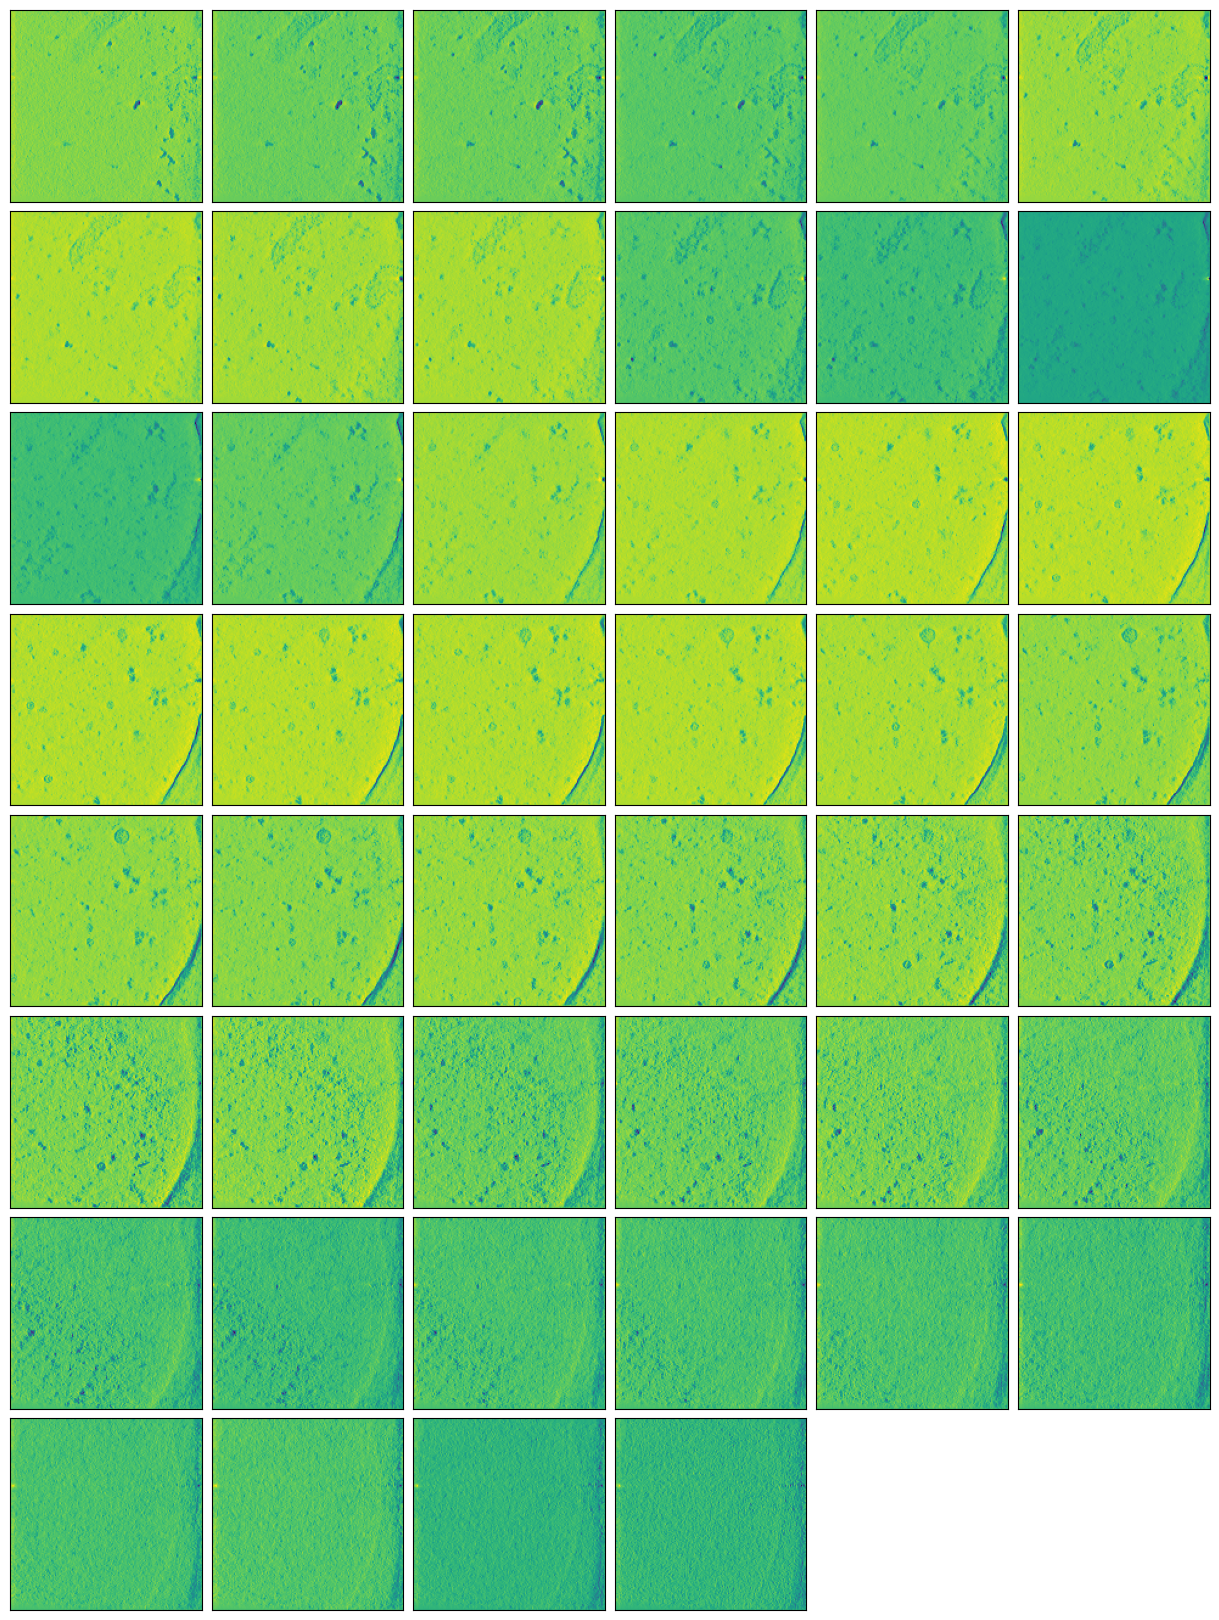

In [8]:
# Images
zarr_group = read_zarr(runs[0])
plot_zarr_images(zarr_group[2])  # index 2: low resolution array

In [9]:
def _normalize_array(zarr_array: zarr.core.Array) -> np.ndarray:
    """Normalize each slice of the array."""
    arr = np.array(zarr_array)
    mins = arr.min(axis=(1, 2), keepdims=True)
    maxs = arr.max(axis=(1, 2), keepdims=True)
    arr = ((arr - mins) / (maxs - mins) * 255).astype(np.uint8)
    return arr

def _plot_slice_surface(array: zarr.core.Array, z_index: int):
    """Plot surface plot of specified z-slice of array."""
    return go.Surface(
        z=z_index * np.ones((array.shape[1], array.shape[2])),
        surfacecolor=array[z_index],
        colorscale="gray",
        cmin=0,
        cmax=255,
        showscale=False,
    )

def plot_animatable_slices(
    arr: zarr.core.Array,
    step: int = 10,
    init_z: int = 0,
    title: str = "",
    fig: plotly.graph_objs._figure.Figure | None = None,
) -> plotly.graph_objs._figure.Figure:
    """Plot animatable slices."""
    base_traces = list(fig.data) if fig is not None else []

    arr = _normalize_array(arr)
    z_dim = len(arr)

    # Z-indices to annimate
    z_indices = range(0, z_dim, step)

    # Initial plot
    fig = go.Figure(
        data=base_traces + [_plot_slice_surface(arr, init_z)],
        layout=go.Layout(
            title=title,
            scene=dict(
                yaxis=dict(autorange="reversed"),
                zaxis=dict(range=[0, z_dim], autorange=False),
                aspectratio=dict(x=1, y=1, z=1),
                camera=dict(eye=dict(x=1.25, y=-1.25, z=1.25)),
            ),
            width=800,
            height=800,
            template="plotly_dark",
            updatemenus=[
                dict(
                    type="buttons",
                    buttons=[
                        dict(
                            label="▶",
                            method="animate",
                            args=[
                                None,
                                dict(
                                    frame=dict(duration=500, redraw=True),
                                    fromcurrent=True,
                                ),
                            ],
                        )
                    ],
                    font=dict(color="black"),
                )
            ],
        ),
    )

    # Set annimation frames
    frames = []
    for i in z_indices:
        frame = go.Frame(data=base_traces + [_plot_slice_surface(arr, i)], name=str(i))
        frames.append(frame)
    fig.frames = frames

    # Setup slider
    sliders = [
        dict(
            active=0,
            currentvalue=dict(prefix="z-index: "),
            pad=dict(t=50),
            steps=[
                dict(
                    label=str(i),
                    method="animate",
                    args=[
                        [str(i)],
                        dict(
                            mode="immediate",
                            frame=dict(duration=200, redraw=True),
                            transition=dict(duration=0),
                        ),
                    ],
                )
                for i in z_indices
            ],
        )
    ]
    fig.update_layout(sliders=sliders)
    return fig

In [10]:
run = runs[0]
df = read_run(run)
fig = plot_particles(df, scale=0.1)
zarr_group = read_zarr(run)
plot_animatable_slices(zarr_group[0], title=df.run_name.iloc[0], fig=fig)